In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

**The class is defined as a subclass of PyTorch's nn.Module.**

d_model: Dimensionality of the input.
num_heads: The number of attention heads to split the input into.
The initialization checks if d_model is divisible by num_heads, and then defines the transformation weights for query, key, value, and output.

**Scaled Dot-Product Attention:**
Calculating Attention Scores: attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k). Here, the attention scores are calculated by taking the dot product of queries (Q) and keys (K), and then scaling by the square root of the key dimension (d_k).
Applying Mask: If a mask is provided, it is applied to the attention scores to mask out specific values.
Calculating Attention Weights: The attention scores are passed through a softmax function to convert them into probabilities that sum to 1.
Calculating Output: The final output of the attention is calculated by multiplying the attention weights by the values (V).



**Splitting Heads:**

```
def split_heads(self, x):
```
This method reshapes the input x into the shape (batch_size, num_heads, seq_length, d_k). It enables the model to process multiple attention heads concurrently, allowing for parallel computation.


Combine Heads:

```
def combine_heads(self, x):
```

After applying attention to each head separately, this method combines the results back into a single tensor of shape (batch_size, seq_length, d_model). This prepares the result for further processing.


**Forward Method:**

```
def forward(self, Q, K, V, mask=None):
```



The forward method is where the actual computation happens:

Apply Linear Transformations: The queries (Q), keys (K), and values (V) are first passed through linear transformations using the weights defined in the initialization.
Split Heads: The transformed Q, K, V are split into multiple heads using the split_heads method.
Apply Scaled Dot-Product Attention: The scaled_dot_product_attention method is called on the split heads.
Combine Heads: The results from each head are combined back into a single tensor using the combine_heads method.
Apply Output Transformation: Finally, the combined tensor is passed through an output linear transformation.

**In summary, the MultiHeadAttention class encapsulates the multi-head attention mechanism commonly used in transformer models. It takes care of splitting the input into multiple attention heads, applying attention to each head, and then combining the results. By doing so, the model can capture various relationships in the input data at different scales, improving the expressive ability of the model.**

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

**Position-wise Feed-Forward Networks**
d_model: Dimensionality of the model's input and output.
d_ff: Dimensionality of the inner layer in the feed-forward network.
self.fc1 and self.fc2: Two fully connected (linear) layers with input and output dimensions as defined by d_model and d_ff.
self.relu: ReLU (Rectified Linear Unit) activation function, which introduces non-linearity between the two linear layers.

**Forward Method:**

x: The input to the feed-forward network.
self.fc1(x): The input is first passed through the first linear layer (fc1).
self.relu(...): The output of fc1 is then passed through a ReLU activation function. ReLU replaces all negative values with zeros, introducing non-linearity into the model.
self.fc2(...): The activated output is then passed through the second linear layer (fc2), producing the final output.

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

**The forward method simply adds the positional encodings to the input x.**

It uses the first x.size(1) elements of pe to ensure that the positional encodings match the actual sequence length of x.

Summary

The PositionalEncoding class adds information about the position of tokens within the sequence. Since the transformer model lacks inherent knowledge of the order of tokens (due to its self-attention mechanism), this class helps the model to consider the position of tokens in the sequence. The sinusoidal functions used are chosen to allow the model to easily learn to attend to relative positions, as they produce a unique and smooth encoding for each position in the sequence.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

Input:

x: The input to the encoder layer.
mask: Optional mask to ignore certain parts of the input.
Processing Steps:

Self-Attention: The input x is passed through the multi-head self-attention mechanism.
Add & Normalize (after Attention): The attention output is added to the original input (residual connection), followed by dropout and normalization using norm1.
Feed-Forward Network: The output from the previous step is passed through the position-wise feed-forward network.
Add & Normalize (after Feed-Forward): Similar to step 2, the feed-forward output is added to the input of this stage (residual connection), followed by dropout and normalization using norm2.
Output: The processed tensor is returned as the output of the encoder layer.

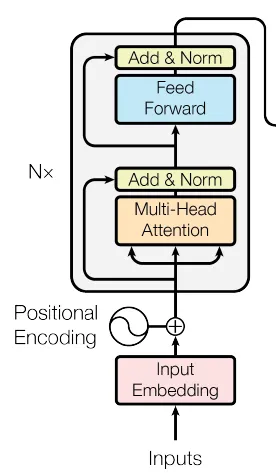

Summary:

The EncoderLayer class defines a single layer of the transformer's encoder. It encapsulates a multi-head self-attention mechanism followed by position-wise feed-forward neural network, with residual connections, layer normalization, and dropout applied as appropriate. These components together allow the encoder to capture complex relationships in the input data and transform them into a useful representation for downstream tasks. Typically, multiple such encoder layers are stacked to form the complete encoder part of a transformer model.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

**Input:**

**x: The input to the decoder layer.**
enc_output: The output from the corresponding encoder (used in the cross-attention step).
src_mask: Source mask to ignore certain parts of the encoder's output.
tgt_mask: Target mask to ignore certain parts of the decoder's input.

**Processing Steps:**

Self-Attention on Target Sequence: The input x is processed through a self-attention mechanism.
Add & Normalize (after Self-Attention): The output from self-attention is added to the original x, followed by dropout and normalization using norm1.
Cross-Attention with Encoder Output: The normalized output from the previous step is processed through a cross-attention mechanism that attends to the encoder's output enc_output.
Add & Normalize (after Cross-Attention): The output from cross-attention is added to the input of this stage, followed by dropout and normalization using norm2.
Feed-Forward Network: The output from the previous step is passed through the feed-forward network.
Add & Normalize (after Feed-Forward): The feed-forward output is added to the input of this stage, followed by dropout and normalization using norm3.
Output: The processed tensor is returned as the output of the decoder layer.
Summary:

The DecoderLayer class defines a single layer of the transformer's decoder. It consists of a multi-head self-attention mechanism, a multi-head cross-attention mechanism (that attends to the encoder's output), a position-wise feed-forward neural network, and the corresponding residual connections, layer normalization, and dropout layers. This combination enables the decoder to generate meaningful outputs based on the encoder's representations, taking into account both the target sequence and the source sequence. As with the encoder, multiple decoder layers are typically stacked to form the complete decoder part of a transformer model.

Next, the Encoder and Decoder blocks are brought together to construct the comprehensive Transformer model.

**DECODER**

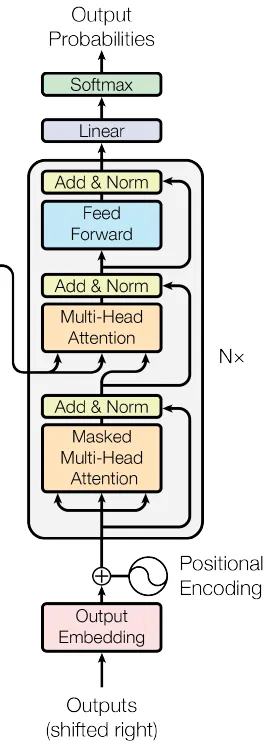

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [ ]:
# Combining the Encoder and Decoder layers to create the complete Transformer network

The constructor takes the following parameters:

src_vocab_size: Source vocabulary size.
tgt_vocab_size: Target vocabulary size.
d_model: The dimensionality of the model's embeddings.
num_heads: Number of attention heads in the multi-head attention mechanism.
num_layers: Number of layers for both the encoder and the decoder.
d_ff: Dimensionality of the inner layer in the feed-forward network.
max_seq_length: Maximum sequence length for positional encoding.
dropout: Dropout rate for regularization.


And it defines the following components:

self.encoder_embedding: Embedding layer for the source sequence.
self.decoder_embedding: Embedding layer for the target sequence.
self.positional_encoding: Positional encoding component.
self.encoder_layers: A list of encoder layers.
self.decoder_layers: A list of decoder layers.
self.fc: Final fully connected (linear) layer mapping to target vocabulary size.
self.dropout: Dropout layer.






[!img](https://images.datacamp.com/image/upload/v1691083566/Figure_4_The_Transformer_Network_Source_Image_from_the_original_paper_120e177956.png)

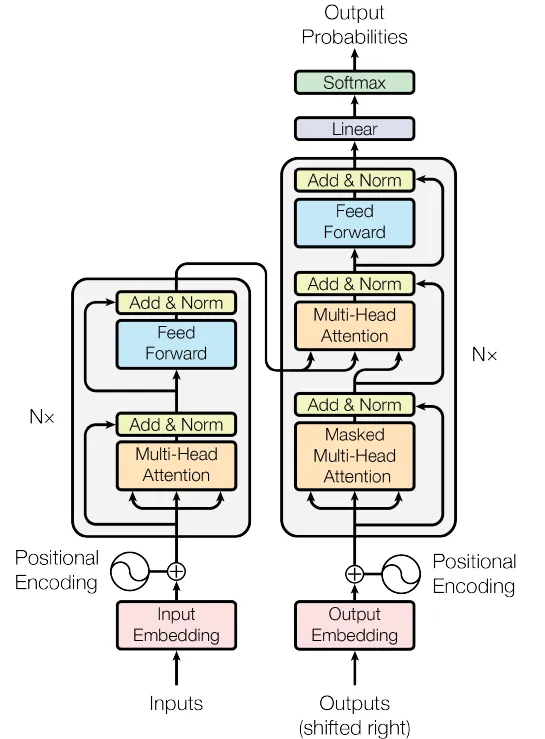


**This method defines the forward pass for the Transformer, taking source and target sequences and producing the output predictions.**

Input Embedding and Positional Encoding: The source and target sequences are first embedded using their respective embedding layers and then added to their positional encodings.
Encoder Layers: The source sequence is passed through the encoder layers, with the final encoder output representing the processed source sequence.
Decoder Layers: The target sequence and the encoder's output are passed through the decoder layers, resulting in the decoder's output.
Final Linear Layer: The decoder's output is mapped to the target vocabulary size using a fully connected (linear) layer.
Output:

The final output is a tensor representing the model's predictions for the target sequence.

Summary:

The Transformer class brings together the various components of a Transformer model, including the embeddings, positional encoding, encoder layers, and decoder layers. It provides a convenient interface for training and inference, encapsulating the complexities of multi-head attention, feed-forward networks, and layer normalization.

This implementation follows the standard Transformer architecture, making it suitable for sequence-to-sequence tasks like machine translation, text summarization, etc. The inclusion of masking ensures that the model adheres to the causal dependencies within sequences, ignoring padding tokens and preventing information leakage from future tokens.

These sequential steps empower the Transformer model to efficiently process input sequences and produce corresponding output sequences.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

Let's take a detailed look at the line:

python
Copy code
src_mask, tgt_mask = self.generate_mask(src, tgt)
This line calls the generate_mask() function, which returns two masks: src_mask for the source sequence and tgt_mask for the target sequence. These masks help control which parts of the input sequences can be attended to in the Transformer architecture.

Purpose of the generate_mask() function
In a Transformer model, masks are crucial because:

Source mask (src_mask): Ensures that padding tokens in the source sequence (usually represented by 0s) do not contribute to the attention mechanism.
Target mask (tgt_mask): Ensures that padding tokens in the target sequence are masked and enforces autoregressive behavior, meaning the model should only attend to previous tokens and not "peek" at future tokens in the target sequence during training.
Detailed Breakdown
1. src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
Input: src is the source sequence, a tensor of shape (batch_size, src_seq_length).
For example, src = [[5, 9, 0], [7, 3, 0]], where 0 represents padding.
Step-by-Step Explanation:
src != 0: This operation creates a boolean mask where every non-zero element is True (indicating valid tokens) and every zero (padding) element is False.
Output: A boolean tensor of shape (batch_size, src_seq_length). In our example:
plaintext
Copy code
[[True, True, False],
 [True, True, False]]
unsqueeze(1): This adds a new dimension at position 1, changing the shape from (batch_size, src_seq_length) to (batch_size, 1, src_seq_length).
Why this step?: This extra dimension is necessary for the attention mechanism to properly broadcast the mask when computing attention scores.
Output in our example:
plaintext
Copy code
[[[True, True, False]],
 [[True, True, False]]]
unsqueeze(2): This adds another dimension at position 2, changing the shape to (batch_size, 1, 1, src_seq_length).
Why this step?: The mask now has dimensions that match the query-key-value matrix used in the self-attention mechanism. This allows the mask to be applied during attention computation (for each head of the Transformer model).
Output in our example:
plaintext
Copy code
[[[[True, True, False]]],
 [[[True, True, False]]]]
Final shape of src_mask: (batch_size, 1, 1, src_seq_length).
2. tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
Input: tgt is the target sequence, a tensor of shape (batch_size, tgt_seq_length).
For example, tgt = [[4, 2, 0], [6, 0, 0]], where 0 represents padding.
Step-by-Step Explanation:
tgt != 0: Similar to the source mask, this creates a boolean tensor where non-padding elements are True and padding elements are False.
Output: A boolean tensor of shape (batch_size, tgt_seq_length). In our example:
plaintext
Copy code
[[True, True, False],
 [True, False, False]]
unsqueeze(1): Adds a new dimension at position 1, changing the shape to (batch_size, 1, tgt_seq_length). This is necessary to prepare the mask for the multi-headed attention mechanism.
Output in our example:
plaintext
Copy code
[[[True, True, False]],
 [[True, False, False]]]
unsqueeze(3): Adds a new dimension at position 3, changing the shape to (batch_size, 1, tgt_seq_length, 1). This final step ensures that the mask can be applied correctly to the attention computation in the decoder.
Output in our example:
plaintext
Copy code
[[[[True], [True], [False]]],
 [[[True], [False], [False]]]]
Final shape of tgt_mask at this point: (batch_size, 1, tgt_seq_length, 1).
3. seq_length = tgt.size(1)
This line retrieves the sequence length of the target sequence.
Input: tgt.size(1) returns the second dimension of tgt, which corresponds to tgt_seq_length.
Example: If tgt is of shape (2, 3), then seq_length = 3.
4. nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
This creates a "no-peak" mask, which prevents the model from attending to future tokens in the sequence (important for autoregressive training). The idea is to allow attention only to the current token and earlier tokens, preventing the model from cheating by looking at future tokens.

Step-by-Step Explanation:
torch.ones(1, seq_length, seq_length): Creates a tensor of ones with shape (1, seq_length, seq_length).
Example (for seq_length = 3):
plaintext
Copy code
[[[1, 1, 1],
  [1, 1, 1],
  [1, 1, 1]]]
torch.triu(..., diagonal=1): This keeps only the upper triangular part of the matrix (starting from the first diagonal above the main one) and sets the lower triangular part to zero.
Example:
plaintext
Copy code
[[[0, 1, 1],
  [0, 0, 1],
  [0, 0, 0]]]
1 - torch.triu(...): Subtracts the result from 1, effectively flipping the matrix, so the lower triangular part becomes 1 (valid positions) and the upper triangular part becomes 0 (masked positions).
Example:
plaintext
Copy code
[[[1, 0, 0],
  [1, 1, 0],
  [1, 1, 1]]]
.bool(): Converts this matrix into a boolean tensor, where 1 becomes True and 0 becomes False.
Final nopeak_mask:
plaintext
Copy code
[[[True, False, False],
  [True, True, False],
  [True, True, True]]]
Shape: (1, seq_length, seq_length).
5. tgt_mask = tgt_mask & nopeak_mask
This combines the target padding mask (tgt_mask) with the "no-peak" mask (nopeak_mask). The & operator applies element-wise logical AND.

The resulting mask ensures that:

Padding tokens are masked (from tgt_mask).
Future positions are masked (from nopeak_mask).
Shape of tgt_mask: After the logical AND operation, the shape is (batch_size, 1, tgt_seq_length, tgt_seq_length).

Example (combined tgt_mask): For tgt = [[4, 2, 0], [6, 0, 0]], after applying both masks:

plaintext
Copy code
[[[[True, False, False],  # First target token can attend to itself
   [True, True, False],   # Second token can attend to itself and the first token
   [False, False, False]]],  # Third token is padding and should not attend anywhere

 [[[True, False, False],   # First token in the second batch attends to itself
   [False, False, False],  # Padding token, no attention
   [False, False, False]]]]
Final Output of generate_mask()
src_mask: Shape (batch_size, 1, 1, src_seq_length). This mask prevents attention to padding tokens in the source sequence.
tgt_mask: Shape (batch_size, 1, tgt_seq_length, tgt_seq_length). This mask prevents attention to padding tokens and future tokens in the target sequence.
Example with Dimensions:
For batch_size = 2, src_seq_length = 3, and tgt_seq_length = 3:

Source (src):

plaintext
Copy code
[[5, 9, 0],
 [7, 3, 0]]
Shape: (2, 3).
Target (tgt):

plaintext
Copy code
[[4, 2, 0],
 [6, 0, 0]]
Shape: (2, 3).
Generated Masks:

src_mask: Shape (2, 1, 1, 3).

plaintext
Copy code
[[[[True, True, False]]],
 [[[True, True, False]]]]
tgt_mask: Shape (2, 1, 3, 3).

plaintext
Copy code
[[[[True, False, False],
    [True, True, False],
    [False, False, False]]],
 [[[True, False, False],
    [False, False, False],
    [False, False, False]]]]







he Purpose of the No-Peak Mask
In a Transformer model, the decoder is used to generate target sequences. During training, the model shouldn't be able to "peek" at future tokens when predicting the current token, meaning it can only attend to the current token and previous tokens. This is where the "no-peak" mask comes in. The mask prevents the model from seeing future tokens by blocking attention to them.

nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
Step-by-Step Explanation
torch.ones(1, seq_length, seq_length)

This creates a 3D tensor of ones with shape (1, seq_length, seq_length).
The 1 in the first dimension is just for batch size consistency (to make the shape compatible with other tensors in the model).
seq_length is the length of the target sequence. This tensor is filled with ones.
Example when seq_length = 4:

[[[1, 1, 1, 1],
  [1, 1, 1, 1],
  [1, 1, 1, 1],
  [1, 1, 1, 1]]]
torch.triu(..., diagonal=1)

torch.triu() returns the upper triangular part of a matrix, setting all elements below the specified diagonal to zero.
diagonal=1 means the diagonal and everything above it is preserved, but everything below the diagonal is zeroed out.
The result for seq_length = 4:

[[[0, 1, 1, 1],
  [0, 0, 1, 1],
  [0, 0, 0, 1],
  [0, 0, 0, 0]]]
This matrix prevents the decoder from attending to future tokens by marking positions above the diagonal as 1 (future tokens).
1 - torch.triu(...)

This operation flips the matrix. Wherever there was a 1, it becomes 0 (masking those positions). Wherever there was a 0, it becomes 1 (indicating that attention is allowed).
The result for seq_length = 4:

[[[1, 0, 0, 0],
  [1, 1, 0, 0],
  [1, 1, 1, 0],
  [1, 1, 1, 1]]]
Now, the model can attend to the current position (diagonal) and previous positions (below the diagonal), but cannot attend to any future positions (above the diagonal is zeroed out).
.bool()

Converts the matrix to a boolean tensor, where 1 becomes True and 0 becomes False.
The final mask for seq_length = 4 looks like this:


[[[True, False, False, False],
  [True, True, False, False],
  [True, True, True, False],
  [True, True, True, True]]]
This mask ensures that at each position in the target sequence, the model can only attend to that position or any earlier ones. It cannot look at future positions during training, which is crucial for autoregressive generation where you predict one token at a time.
Why is This Important?
In an autoregressive task (e.g., machine translation or text generation), the model generates the output sequence token by token. For each token, the model should only rely on the tokens it has already generated (previous tokens) and not the future tokens.

The no-peak mask achieves this by making sure that when predicting the next token, the model can only attend to the tokens it has already predicted (the previous ones), not the ones that come after. This prevents the model from "cheating" during training by looking at future tokens and forces it to learn the proper sequence relationships.

In [ ]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

Training Loop:

The code snippet trains the model for 100 epochs using a typical training loop:

for epoch in range(100): Iterates over 100 training epochs.
optimizer.zero_grad(): Clears the gradients from the previous iteration.
output = transformer(src_data, tgt_data[:, :-1]): Passes the source data and the target data (excluding the last token in each sequence) through the transformer. This is common in sequence-to-sequence tasks where the target is shifted by one token.
loss = criterion(...): Computes the loss between the model's predictions and the target data (excluding the first token in each sequence). The loss is calculated by reshaping the data into one-dimensional tensors and using the cross-entropy loss function.
loss.backward(): Computes the gradients of the loss with respect to the model's parameters.
optimizer.step(): Updates the model's parameters using the computed gradients.
print(f"Epoch: {epoch+1}, Loss: {loss.item()}"): Prints the current epoch number and the loss value for that epoch.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Summary:

This code snippet trains the transformer model on randomly generated source and target sequences for 100 epochs. It uses the Adam optimizer and the cross-entropy loss function. The loss is printed for each epoch, allowing you to monitor the training progress. In a real-world scenario, you would replace the random source and target sequences with actual data from your task, such as machine translation.



In [ ]:
transformer.eval()

# Generate random sample validation data
val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")

Evaluation Mode:

transformer.eval(): Puts the transformer model in evaluation mode. This is important because it turns off certain behaviors like dropout that are only used during training.
Generate Random Validation Data:

val_src_data: Random integers between 1 and src_vocab_size, representing a batch of validation source sequences with shape (64, max_seq_length).
val_tgt_data: Random integers between 1 and tgt_vocab_size, representing a batch of validation target sequences with shape (64, max_seq_length).
Validation Loop:

with torch.no_grad(): Disables gradient computation, as we don't need to compute gradients during validation. This can reduce memory consumption and speed up computations.
val_output = transformer(val_src_data, val_tgt_data[:, :-1]): Passes the validation source data and the validation target data (excluding the last token in each sequence) through the transformer.
val_loss = criterion(...): Computes the loss between the model's predictions and the validation target data (excluding the first token in each sequence). The loss is calculated by reshaping the data into one-dimensional tensors and using the previously defined cross-entropy loss function.
print(f"Validation Loss: {val_loss.item()}"): Prints the validation loss value.
Summary:

This code snippet evaluates the transformer model on a randomly generated validation dataset, computes the validation loss, and prints it. In a real-world scenario, the random validation data should be replaced with actual validation data from the task you are working on. The validation loss can give you an indication of how well your model is performing on unseen data, which is a critical measure of the model's generalization ability.

https://images.datacamp.com/image/upload/v1691083566/Figure_4_The_Transformer_Network_Source_Image_from_the_original_paper_120e177956.png